In [11]:
import sys
import os
import time
import warnings
import pandas as pd
import numpy as np
import deepchem as dc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

results = {}


In [12]:
def grid_search_graph_conv(train_dataset, param_grid):
    import itertools
    from deepchem.models import GraphConvModel

    best_score = float('inf')
    best_params = None
    all_results = []

    combinations = list(itertools.product(
        param_grid['batch_size'],
        param_grid['graph_conv_layers'],
        param_grid['dense_layer_size'],
        param_grid['dropout']
    ))

    for batch_size, conv_layers, dense_size, dropout in combinations:
        model = GraphConvModel(1, mode='regression',
                               batch_size=batch_size,
                               graph_conv_layers=conv_layers,
                               dense_layer_size=dense_size,
                               dropout=dropout)
        model.fit(train_dataset, nb_epoch=30)
        metric = dc.metrics.Metric(dc.metrics.mae_score, np.mean)
        scores = model.evaluate(train_dataset, [metric])
        score = scores[metric.name]

        all_results.append({
            'params': (batch_size, conv_layers, dense_size, dropout),
            'mae': score
        })

        if score < best_score:
            best_score = score
            best_params = (batch_size, conv_layers, dense_size, dropout)

    return all_results, best_params
# ⏱️ GCM: Load + Featurize
start_gcm_load = time.time()
tasks = ['measured log solubility in mols per litre']
loader = dc.data.CSVLoader(tasks=tasks, feature_field="smiles", featurizer=dc.feat.ConvMolFeaturizer())
dataset = loader.create_dataset(r"/home/mounir/Downloads/esol.csv")
end_gcm_load = time.time()

# ⏱️ GCM: Split + Grid Search
splitter = dc.splits.RandomSplitter()
train_set, test_set = splitter.train_test_split(dataset, frac_train=0.8, seed=0)

hyper_params = {
    'batch_size': [32, 16],
    'graph_conv_layers': [[128, 128], [256, 256], [512, 512]],
    'dense_layer_size': [512, 256, 128],
    'dropout': [0.0],
}

start_gcm_grid = time.time()
search_results, (batch_size, conv_layers, layer_sizes, dropout_rate) = grid_search_graph_conv(train_set, hyper_params)
end_gcm_grid = time.time()
print(search_results)

# GCM: Normalize + Train
transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_set, move_mean=True)]
for transformer in transformers:
    train_set = transformer.transform(train_set)
    test_set = transformer.transform(test_set)

start_gcm_train = time.time()
model = dc.models.GraphConvModel(1, mode='regression', batch_size=batch_size, 
                                graph_conv_layers=conv_layers, dense_layer_size=layer_sizes, 
                                dropout=dropout_rate)
model.fit(train_set, nb_epoch=100)
end_gcm_train = time.time()

metric = [
    dc.metrics.Metric(dc.metrics.rms_score, np.mean),
    dc.metrics.Metric(dc.metrics.mae_score, np.mean),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)
]

train_scores = model.evaluate(train_set, metric, transformers)
test_scores = model.evaluate(test_set, metric, transformers)
print("Train scores:", train_scores)
print("Test scores:", test_scores)

results['gcm'] = test_scores


2025-05-03 14:27:14.128339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-05-03 14:27:14.128460: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-03 14:27:14.128513: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mounir-HP-ProBook-430-G5): /proc/driver/nvidia/version does not exist
2025-05-03 14:27:14.129238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[{'params': (32, [128, 128], 512, 0.0), 'mae': 0.3411419786760324}, {'params': (32, [128, 128], 256, 0.0), 'mae': 0.3321054005584537}, {'params': (32, [128, 128], 128, 0.0), 'mae': 0.31779297765828424}, {'params': (32, [256, 256], 512, 0.0), 'mae': 0.30771228218223995}, {'params': (32, [256, 256], 256, 0.0), 'mae': 0.30886398712679447}, {'params': (32, [256, 256], 128, 0.0), 'mae': 0.43870427582989513}, {'params': (32, [512, 512], 512, 0.0), 'mae': 0.34230668498856526}, {'params': (32, [512, 512], 256, 0.0), 'mae': 0.2941522884767362}, {'params': (32, [512, 512], 128, 0.0), 'mae': 0.3586544387092083}, {'params': (16, [128, 128], 512, 0.0), 'mae': 0.4017411411961999}, {'params': (16, [128, 128], 256, 0.0), 'mae': 0.35720853314193546}, {'params': (16, [128, 128], 128, 0.0), 'mae': 0.34752503208052815}, {'params': (16, [256, 256], 512, 0.0), 'mae': 0.38601668974420184}, {'params': (16, [256, 256], 256, 0.0), 'mae': 0.3910040142913483}, {'params': (16, [256, 256], 128, 0.0), 'mae': 0.35392

In [14]:
# MPNN: Load + Grid Search
loader = dc.data.CSVLoader(tasks=tasks, feature_field="smiles", featurizer=dc.feat.WeaveFeaturizer())
dataset = loader.create_dataset(r"/home/mounir/Downloads/esol.csv")
train_set, test_set = splitter.train_test_split(dataset, frac_train=0.8, seed=0)
from itertools import product
from deepchem.metrics import Metric, pearson_r2_score

def grid_search_mpnn(train_set, param_grid):
    best_score = -float('inf')
    best_params = None
    all_results = []

    # Iterate over all combinations
    for batch_size, n_atom_feat, n_pair_feat, n_hidden in product(
        param_grid['batch_size'],
        param_grid['n_atom_feat'],
        param_grid['n_pair_feat'],
        param_grid['n_hidden']
    ):
        try:
            model = dc.models.MPNNModel(
                1,
                mode='regression',
                batch_size=batch_size,
                use_queue=False,
                n_atom_feat=n_atom_feat,
                n_pair_feat=n_pair_feat,
                n_hidden=n_hidden,
                learning_rate=0.0001,
                T=3,
                M=5
            )
            model.fit(train_set, nb_epoch=10)
            score = model.evaluate(train_set, [Metric(pearson_r2_score)])['pearson_r2_score']
            all_results.append((score, batch_size, n_atom_feat, n_pair_feat, n_hidden))
            print(f"R²={score:.4f} with batch_size={batch_size}, n_atom_feat={n_atom_feat}, n_pair_feat={n_pair_feat}, n_hidden={n_hidden}")
            if score > best_score:
                best_score = score
                best_params = (batch_size, n_atom_feat, n_pair_feat, n_hidden)
        except Exception as e:
            print(f" Failed with config: {batch_size}, {n_atom_feat}, {n_pair_feat}, {n_hidden}: {e}")
            continue

    return all_results, best_params


hyper_params = {
    'batch_size': [32, 16],
    'n_atom_feat': [75],
    'n_pair_feat': [14],
    'n_hidden': [100]
}

start_mpnn_grid = time.time()
search_results, (batch_size, n_atom_feat, n_pair_feat, n_hidden) = grid_search_mpnn(train_set, hyper_params)
end_mpnn_grid = time.time()
print(search_results)

transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_set, move_mean=True)]
for transformer in transformers:
    train_set = transformer.transform(train_set)
    test_set = transformer.transform(test_set)

start_mpnn_train = time.time()
model = dc.models.MPNNModel(1, mode='regression', batch_size=batch_size, use_queue=False, 
                           n_atom_feat=n_atom_feat, n_pair_feat=n_pair_feat, n_hidden=n_hidden, 
                           learning_rate=0.0001, T=3, M=5)
model.fit(train_set, nb_epoch=50, checkpoint_interval=100)
end_mpnn_train = time.time()

train_scores = model.evaluate(train_set, metric, transformers)
test_scores = model.evaluate(test_set, metric, transformers)
print("Train scores:", train_scores)
print("Test scores:", test_scores)

results['mpnn'] = test_scores


R²=0.8664 with batch_size=32, n_atom_feat=75, n_pair_feat=14, n_hidden=100
R²=0.8965 with batch_size=16, n_atom_feat=75, n_pair_feat=14, n_hidden=100
[(0.8663988019296947, 32, 75, 14, 100), (0.8965469640466585, 16, 75, 14, 100)]
Train scores: {'mean-rms_score': 0.3640923233560647, 'mean-mae_score': 0.2768712091554974, 'mean-pearson_r2_score': 0.9763473876724266}
Test scores: {'mean-rms_score': 0.595825894491425, 'mean-mae_score': 0.44313396924877957, 'mean-pearson_r2_score': 0.9343892190957103}


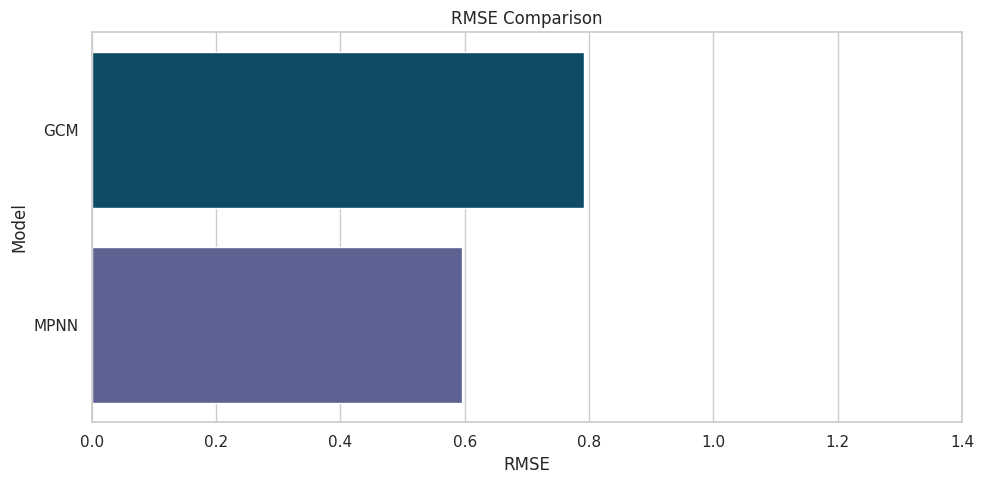

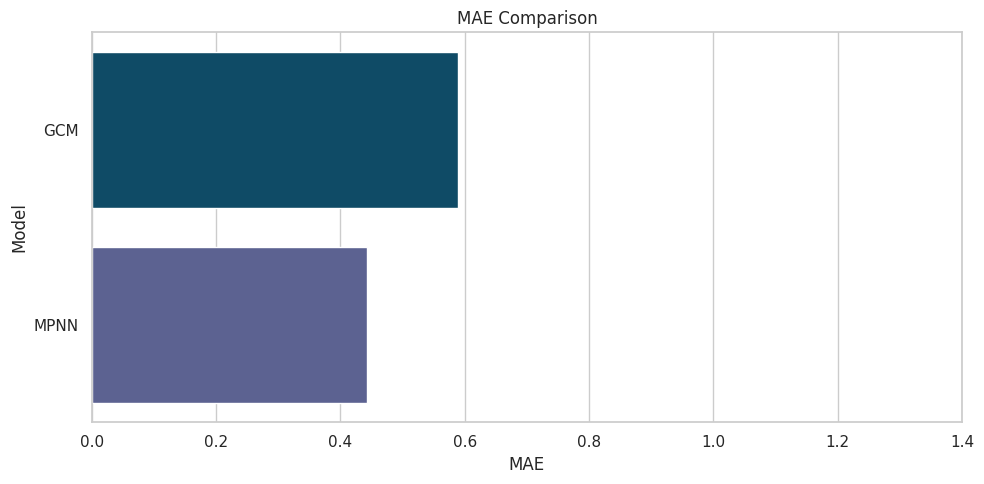

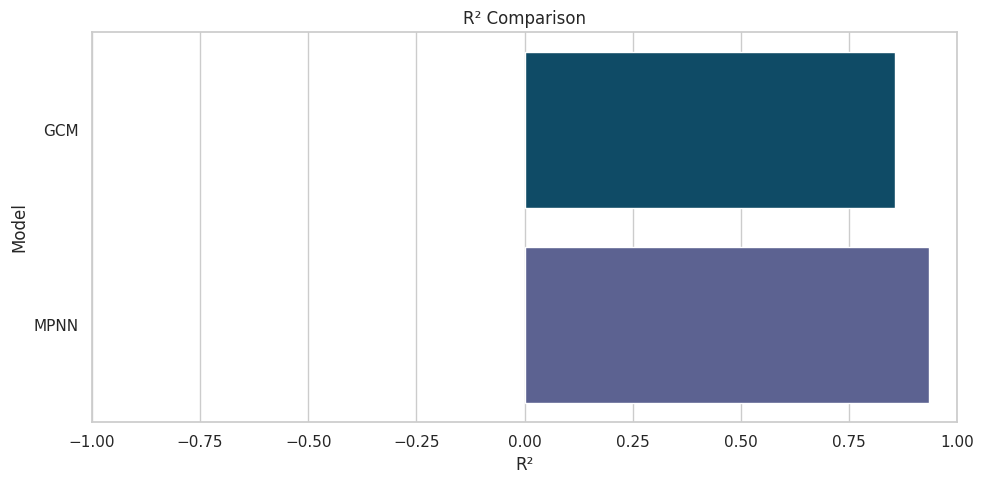

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent styling
sns.set(style="whitegrid")
color_palette = ['#005075', '#535b9a']  # Only 2 colors for 2 models
score_keys = ['mean-rms_score', 'mean-mae_score', 'mean-pearson_r2_score']
plot_titles = ['RMSE', 'MAE', 'R²']

for score_key, plot_title in zip(score_keys, plot_titles):
    scores = [results['gcm'][score_key], results['mpnn'][score_key]]
    model_labels = ['GCM', 'MPNN']

    plt.figure(figsize=(10, 5))
    sns.barplot(x=scores, y=model_labels, palette=color_palette)
    plt.title(f"{plot_title} Comparison")
    plt.xlim([0, 1.4]) if plot_title != 'R²' else plt.xlim([-1, 1])
    plt.xlabel(plot_title)
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()


In [17]:
print("\n Non-Spark Execution Summary")
print(f"GCM Load Time:        {end_gcm_load - start_gcm_load:.2f} s")
print(f"GCM Grid Search Time: {end_gcm_grid - start_gcm_grid:.2f} s")
print(f"GCM Train Time:       {end_gcm_train - start_gcm_train:.2f} s")

print(f"MPNN Grid Search Time:{end_mpnn_grid - start_mpnn_grid:.2f} s")
print(f"MPNN Train Time:      {end_mpnn_train - start_mpnn_train:.2f} s")




 Non-Spark Execution Summary
GCM Load Time:        4.14 s
GCM Grid Search Time: 1692.53 s
GCM Train Time:       172.13 s
MPNN Grid Search Time:502.77 s
MPNN Train Time:      1487.20 s


In [18]:
# Save each model to a separate variable (do this AFTER training each model)
model_gcm = model if isinstance(model, dc.models.GraphConvModel) else None
model_mpnn = model if isinstance(model, dc.models.MPNNModel) else None
model_rf = model if isinstance(model, dc.models.SklearnModel) else None

# Unified prediction function
from IPython.display import display, clear_output
from ipywidgets import widgets, VBox, HBox
from rdkit import Chem
from rdkit.Chem import Draw

def predict_with_model(smiles, selected_model):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None, " Invalid SMILES"

    feats = featurizer.featurize([mol])
    dataset = dc.data.NumpyDataset(X=np.array(feats))

    try:
        if selected_model == "GraphConvModel" and model_gcm:
            pred = model_gcm.predict(dataset)[0][0]
        elif selected_model == "MPNNModel" and model_mpnn:
            pred = model_mpnn.predict(dataset)[0][0]
        elif selected_model == "RandomForest" and model_rf:
            pred = model_rf.predict(dataset)[0][0]
        else:
            return None, f" {selected_model} is not available."
    except Exception as e:
        return None, f"Prediction error: {e}"

    return mol, f"Predicted log solubility: {pred:.2f}"

# Interactive widget launcher
def launch_predictor_interface():
    model_selector = widgets.Dropdown(
        options=['GraphConvModel', 'MPNNModel', 'RandomForest'],
        value='GraphConvModel',
        description='Model:',
        style={'description_width': 'initial'}
    )
    smiles_input = widgets.Text(
        value='CCO',
        description='SMILES:',
        placeholder='Enter a SMILES string',
        layout=widgets.Layout(width='60%')
    )
    predict_button = widgets.Button(description='Predict', button_style='success')
    output = widgets.Output()

    def on_click(_):
        with output:
            clear_output()
            smiles = smiles_input.value.strip()
            model_choice = model_selector.value
            mol, result = predict_with_model(smiles, model_choice)

            if mol:
                display(Draw.MolToImage(mol, size=(250, 250)))
            print(result)

    predict_button.on_click(on_click)
    display(VBox([
        widgets.HTML("<h3 style='color:#1f77b4;'> Interactive Solubility Predictor</h3>"),
        HBox([smiles_input, model_selector, predict_button]),
        output
    ]))

launch_predictor_interface()
